In [1403]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from config import *

## **Test/Positve dataset**

1. **Dataset before 2020-05-12**

In [1404]:
url_test1="https://www.data.gouv.fr/fr/datasets/r/b4ea7b4b-b7d1-4885-a099-71852291ff20"
dtype={'dep': str,'clage_covid':str,'nb_test':int,'nb_pos':int}
df_test1=pd.read_csv(url_test1,sep = ';',dtype=dtype)
df_test1=df_test1.drop(["nb_test_h","nb_test_f","nb_pos_h","nb_pos_f"],axis=1)

In [1405]:
df_test1=df_test1.drop(df_test1[(df_test1["jour"]<"2020-03-18") | (df_test1["jour"]>"2020-05-12")].index)
df_test1.head()

,dep,jour,clage_covid,nb_test,nb_pos
48,01,2020-03-18,0,37,8
49,01,2020-03-18,A,0,0
50,01,2020-03-18,B,15,1
51,01,2020-03-18,C,11,3
52,01,2020-03-18,D,4,3


In [1406]:
df_test1=df_test1.drop(df_test1[df_test1["clage_covid"] != "0"].index)
df_test1=df_test1.drop("clage_covid",axis=1)
df_test1.head()

,dep,jour,nb_test,nb_pos
48,01,2020-03-18,37,8
54,01,2020-03-19,82,13
60,01,2020-03-20,44,9
66,01,2020-03-21,13,1
72,01,2020-03-22,4,0


2. **Dataset after 2020-05-12**

In [1407]:
url_test2="https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675"
dtype={'dep': str,'P':int,'T':int,'cl_age':int}
df_test2=pd.read_csv(url_test2,sep = ';',dtype=dtype)
df_test2.head()

,dep,jour,P,T,cl_age90
0,01,2020-05-13,0,16,9
1,01,2020-05-13,1,16,19
2,01,2020-05-13,0,31,29
3,01,2020-05-13,1,71,39
4,01,2020-05-13,0,52,49


In [1408]:
df_test2.loc[df_test2['dep'] == '75']

,dep,jour,P,T,cl_age90
145200,75,2020-05-13,0,62,9
145201,75,2020-05-13,0,40,19
145202,75,2020-05-13,6,188,29
145203,75,2020-05-13,2,234,39
145204,75,2020-05-13,2,206,49
...,...,...,...,...,...
147131,75,2020-11-04,137,842,69
147132,75,2020-11-04,65,415,79
147133,75,2020-11-04,22,184,89
147134,75,2020-11-04,20,90,90


In [1409]:
df_test2=df_test2.rename(columns={'P':'nb_pos','T':'nb_test'})
df_test2=df_test2.drop("cl_age90",axis=1)

In [1410]:
df_test2=df_test2.groupby(["dep","jour"]).tail(1)
df_test2.head()

,dep,jour,nb_pos,nb_test
10,01,2020-05-13,9,324
21,01,2020-05-14,9,429
32,01,2020-05-15,5,438
43,01,2020-05-16,0,142
54,01,2020-05-17,0,30


3. **Merge in one dataset**

In [1411]:
df_test = pd.concat([df_test1,df_test2],ignore_index=True)
df_test['nb_test_cum']=df_test.groupby("dep")['nb_test'].cumsum()
df_test['nb_pos_cum']=df_test.groupby("dep")['nb_pos'].cumsum()
df_test.head()

,dep,jour,nb_test,nb_pos,nb_test_cum,nb_pos_cum
0,01,2020-03-18,37,8,37,8
1,01,2020-03-19,82,13,119,21
2,01,2020-03-20,44,9,163,30
3,01,2020-03-21,13,1,176,31
4,01,2020-03-22,4,0,180,31


## **Hospital dataset**

In [1412]:
url2="https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
df_hospital = pd.read_csv(url2,sep=';')
df_hospital.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [1413]:
df_hospital = df_hospital.drop(df_hospital[(df_hospital["sexe"]==1) | (df_hospital["sexe"]==2 ) ].index).reset_index(drop=True)
df_hospital = df_hospital.drop(["sexe"],axis=1)
df_hospital.head()

,dep,jour,hosp,rea,rad,dc
0,01,2020-03-18,2,0,1,0
1,02,2020-03-18,41,10,18,11
2,03,2020-03-18,4,0,1,0
3,04,2020-03-18,3,1,2,0
4,05,2020-03-18,8,1,9,0


## **Create departement longitude/latitude Dataframe**

Source: <a href="https://www.ign.fr/sites/default/files/2020-09/Quels%20sont%20les%20centres%20des%2096%20d%C3%A9partements%20m%C3%A9tropolitains.pdf" target="_blank">https://www.ign.fr/sites/default/files/2020-09/Quels%20sont%20les%20centres%20des%2096%20d%C3%A9partements%20m%C3%A9tropolitains.pdf</a>

Source: <a href="https://www.coordonnees-gps.fr/" target="_blank">https://www.coordonnees-gps.fr/</a>

In [1414]:
departements= df_test["dep"].unique()
zoom_dep=[7.5]*len(departements)

In [1415]:
data={'dep':departements,
      'dep_name':['Ain','Aisne','Allier','Alpes-de-Haute-Provence','Hautes-Alpes','Alpes_Maritimes','Ardeche','Ardennes','Ariege','Aube','Aude','Aveyron','Bouches-du-Rhône','Calvados','Cantal','Charente','Charente-Maritime','Cher','Correze',"Côte-d'Or","Côtes-D'Armor","Creuse","Dordogne","Doubs","Drome","Eure","Eure-et-Loire","Finistère","Corde-du-Sud","Haute-Corse","Gard","Haute-Garonne","Gers","Gironde","Hérault","Ille-et-Vilaine","Indre","Indre-et-Loire","Isère","Jura","Landes","Loir-et-Cher","Loire","Haute-Loire","Loire-Atlantique","Loiret","Lot","Lot-et-Garonne","Lozère","Manne-et-Loire","Manche","Marne","Haute-Marne","Mayenne","Meurthe-et-Moselle","Meuse","Morbihan","Moselle","Nièvre","Nord","Oise","Orne","Pas-de-Calais","Puy-de-Dôme","Pyrénées-Altantiques","Hautes-Pyrénées","Pyrénées-Orientales","Bas-Rhin","Haut-Rhin","Rhone","Haute-Saône","Saône-et-Loire","Sarthe","Savoie","Haute-Savoie","Paris","Seine-Maritime","Seine-et-Marne","Yvellines","Deux-Sèvres","Somme","Tarn","Tarn-et-Garonne","Var","Vaucluse","Vendée","Vienne","Haute-Vienne","Vosges","Yonne","Territoire de Belfort","Essonne","Hauts-de-Seine","Seine-Saint_Denis","Val-de-Marne","Val-d'Oise","Guadeloupe","Martinique","Guyane","La Réunion","Mayotte","Saint-Pierre-et-Miquelon","Saint-Barthélémy","Saint-Martin"],
      'lat':[46.1,49.55,44.1,44.09,44.66,43.94,44.73,49.61,42.94,48.31,43.10,44.28,43.54,49.10,45.01,45.71,45.76,47.07,45.34,47.43,48.44,46.08,45.13,47.16,44.68,49.10,48.39,48.27,41.88,42.37,43.99,43.35,43.68,44.84,43.90,48.18,46.80,47.24,45.27,46.73,43.96,47.61,45.72,45.13,47.38,47.85,44.63,44.37,44.51,47.39,49.08,48.38,48.09,48.12,48.79,49.00,47.85,49.02,47.10,50.45,49.39,48.61,50.49,45.73,43.28,43.05,42.61,48.65,47.86,45.86,47.63,46.64,48.00,45.47,46.04,48.85,49.65,48.60,48.97,46.53,49.97,43.77,44.07,43.47,43.99,46.67,46.55,45.87,48.19,47.84,47.62,48.52,48.83,48.90,48.77,49.07,16.00,14.60,4.93,-20.88,-12.77,46.78,17.90,18.06],
      'long':[5.33,3.56,2.35,6.23,6.21,7.12,4.41,4.61,1.53,4.14,2.35,2.72,5.03,-0.37,2.66,0.20,-0.71,2.52,1.81,4.78,-2.85,2.04,0.70,6.37,5.15,1.00,1.36,-4.04,8.97,9.23,4.17,1.23,0.45,-0.58,4.47,-1.64,1.62,0.69,5.61,5.69,-0.80,1.41,4.16,3.81,-1.71,2.26,1.59,0.46,3.49,-0.53,-1.34,7.47,5.15,-0.67,6.16,5.39,-2.83,6.65,3.51,3.20,2.42,0.11,2.27,3.14,-0.75,0.16,2.51,7.56,7.27,4.66,6.07,4.53,0.19,6.45,6.44,2.35,1.04,2.97,1.97,-0.32,2.29,2.18,1.28,6.18,5.14,-1.28,0.50,1.23,6.37,3.57,6.92,2.26,2.24,2.48,2.45,2.17,-61.73,-61.06,-52.32,55.45,45.22,-56.19,-62.81,-63.08],
      'zoom':zoom_dep
     }
print(len(data['dep_name']))
df_coord = pd.DataFrame(data,columns=['dep','dep_name','lat','long','zoom'])
df_coord.tail()

104


,dep,dep_name,lat,long,zoom
99,974,La Réunion,-20.88,55.45,7.5
100,976,Mayotte,-12.77,45.22,7.5
101,975,Saint-Pierre-et-Miquelon,46.78,-56.19,7.5
102,977,Saint-Barthélémy,17.90,-62.81,7.5
103,978,Saint-Martin,18.06,-63.08,7.5


## **Complete Dataset**

In [1416]:
df_dep = pd.merge(df_hospital,df_test,on=['dep','jour'])
df_dep = pd.merge(df_dep,df_coord,on=['dep'])
df_dep=df_dep.sort_values(['dep','jour'])

In [1417]:
df_dep.head()

,dep,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,zoom
0,01,2020-03-18,2,0,1,0,37,8,37,8,Ain,46.1,5.33,7.5
1,01,2020-03-19,2,0,1,0,82,13,119,21,Ain,46.1,5.33,7.5
2,01,2020-03-20,2,0,1,0,44,9,163,30,Ain,46.1,5.33,7.5
3,01,2020-03-21,4,0,1,0,13,1,176,31,Ain,46.1,5.33,7.5
4,01,2020-03-22,8,1,2,0,4,0,180,31,Ain,46.1,5.33,7.5


In [1418]:
df_dep["scaled"] = df_dep["nb_pos_cum"] ** 0.77
df_dep['death_rate']=round(df_dep['dc']/df_dep['nb_pos_cum']*100,2)
df_dep.head()

,dep,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,zoom,scaled,death_rate
0,01,2020-03-18,2,0,1,0,37,8,37,8,Ain,46.1,5.33,7.5,4.958831,0.0
1,01,2020-03-19,2,0,1,0,82,13,119,21,Ain,46.1,5.33,7.5,10.425787,0.0
2,01,2020-03-20,2,0,1,0,44,9,163,30,Ain,46.1,5.33,7.5,13.720924,0.0
3,01,2020-03-21,4,0,1,0,13,1,176,31,Ain,46.1,5.33,7.5,14.071763,0.0
4,01,2020-03-22,8,1,2,0,4,0,180,31,Ain,46.1,5.33,7.5,14.071763,0.0


In [1419]:
df_dep["new_death_rate"]=df_dep.groupby("dep")["death_rate"].apply(lambda row: row-(row.shift(1)))
df_dep["new_death_rate"].fillna(df_dep["death_rate"], inplace = True) # first date, new_death_rate = death rate
df_dep["new_dc"]=df_dep.groupby("dep")["dc"].apply(lambda row: row-(row.shift(1)))
df_dep["new_dc"].fillna(df_dep["dc"], inplace = True) # first date, new_dc = dc

df_dep.head(15)

,dep,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,zoom,scaled,death_rate,new_death_rate,new_dc
0,01,2020-03-18,2,0,1,0,37,8,37,8,Ain,46.1,5.33,7.5,4.958831,0.00,0.00,0.0
1,01,2020-03-19,2,0,1,0,82,13,119,21,Ain,46.1,5.33,7.5,10.425787,0.00,0.00,0.0
2,01,2020-03-20,2,0,1,0,44,9,163,30,Ain,46.1,5.33,7.5,13.720924,0.00,0.00,0.0
3,01,2020-03-21,4,0,1,0,13,1,176,31,Ain,46.1,5.33,7.5,14.071763,0.00,0.00,0.0
4,01,2020-03-22,8,1,2,0,4,0,180,31,Ain,46.1,5.33,7.5,14.071763,0.00,0.00,0.0
5,01,2020-03-23,17,3,7,0,36,9,216,40,Ain,46.1,5.33,7.5,17.123250,0.00,0.00,0.0
6,01,2020-03-24,22,3,11,0,17,2,233,42,Ain,46.1,5.33,7.5,17.778780,0.00,0.00,0.0
7,01,2020-03-25,29,6,15,0,21,3,254,45,Ain,46.1,5.33,7.5,18.748807,0.00,0.00,0.0
8,01,2020-03-26,33,6,17,2,27,5,281,50,Ain,46.1,5.33,7.5,20.333255,4.00,4.00,2.0
9,01,2020-03-27,49,9,17,2,30,5,311,55,Ain,46.1,5.33,7.5,21.881610,3.64,-0.36,0.0


In [1420]:
df_last_update=df_dep.groupby("dep").tail(1).reset_index(drop=True)
df_last_update.head()

,dep,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,zoom,scaled,death_rate,new_death_rate,new_dc
0,01,2020-11-04,359,36,706,161,2939,821,159515,22186,Ain,46.10,5.33,7.5,2220.653694,0.73,0.00,6.0
1,02,2020-11-04,189,29,1345,327,1747,291,94740,7715,Aisne,49.55,3.56,7.5,984.574688,4.24,-0.10,5.0
2,03,2020-11-04,240,21,386,90,1549,309,72004,5554,Allier,44.10,2.35,7.5,764.445492,1.62,0.02,6.0
3,04,2020-11-04,89,9,213,25,426,118,39010,2706,Alpes-de-Haute-Provence,44.09,6.23,7.5,439.432729,0.92,-0.05,0.0
4,05,2020-11-04,145,21,233,41,415,127,27612,3445,Hautes-Alpes,44.66,6.21,7.5,529.219337,1.19,-0.05,0.0


In [1421]:
df_last_update.iloc[75]

dep                       75
jour              2020-11-04
hosp                    1348
rea                      277
rad                     8550
dc                      2146
nb_test                 6602
nb_pos                  1106
nb_test_cum           838219
nb_pos_cum             89965
dep_name               Paris
lat                    48.85
long                    2.35
zoom                     7.5
scaled               6525.84
death_rate              2.39
new_death_rate         -0.01
new_dc                    15
Name: 75, dtype: object

## **France dataset**

In [1422]:
df_france=df_dep.groupby("jour").sum().reset_index()
df_france['death_rate']=round(df_france['dc']/df_france['nb_pos_cum']*100,2)
df_france['new_death_rate']=df_france.death_rate-df_france.death_rate.shift(1)
df_france["new_death_rate"].fillna(df_france["death_rate"], inplace = True) # first date, new_death_rate = death rate
df_france["lat"]=46.40
df_france["long"]=0.5
df_france["zoom"]=3.5

In [1423]:
df_france.tail()

,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,lat,long,zoom,scaled,death_rate,new_death_rate,new_dc
227,2020-10-31,23013,3443,117563,25113,128916,25906,16573582,1414871,46.4,0.5,3.5,142433.208313,1.77,-0.02,223.0
228,2020-11-01,24008,3569,118196,25344,31895,6724,16605477,1421595,46.4,0.5,3.5,142953.962575,1.78,0.01,231.0
229,2020-11-02,25120,3721,119073,25760,311823,68773,16917300,1490368,46.4,0.5,3.5,148494.840748,1.73,-0.05,416.0
230,2020-11-03,26242,3869,120683,26186,267421,56888,17184721,1547256,46.4,0.5,3.5,153033.059026,1.69,-0.04,426.0
231,2020-11-04,27511,4080,122631,26571,228097,44640,17412818,1591896,46.4,0.5,3.5,156552.806169,1.67,-0.02,385.0


#### **Plot Figures**

### **Map**

In [1424]:
color_scale = ["#fadc8f",
        "#f9d67a",
        "#f8d066",
        "#f8c952",
        "#f7c33d",
        "#f6bd29",
        "#f5b614",
        "#F4B000",
        "#eaa900",
        "#e0a200",
        "#dc9e00",]



In [1425]:
px.set_mapbox_access_token(MAPBOX_ACCESS_TOKEN)

In [1426]:
def plot_map(lat=46.4,lon=0.5,zoom=3.5):    
    fig = px.scatter_mapbox(
        df_last_update,
        lat = "lat",
        lon = "long",
        color = "nb_pos_cum",
        size="scaled",
        size_max = 35,
        hover_name = "dep_name",
        hover_data = ["nb_pos_cum","dc","death_rate","dep_name"],
        color_continuous_scale = color_scale,
    )

    fig.layout.update(
            mapbox_style="dark",
            mapbox=dict(center=dict(lat=lat, lon=lon), zoom=zoom),
        )
    fig.data[0].update(
            hovertemplate=("%{customdata[3]}<br>Confirmed:"
                          " %{customdata[0]}<br>Deaths: %{customdata[1]}<br>Death Rate: %{customdata[2]}")
        )

    fig.show()

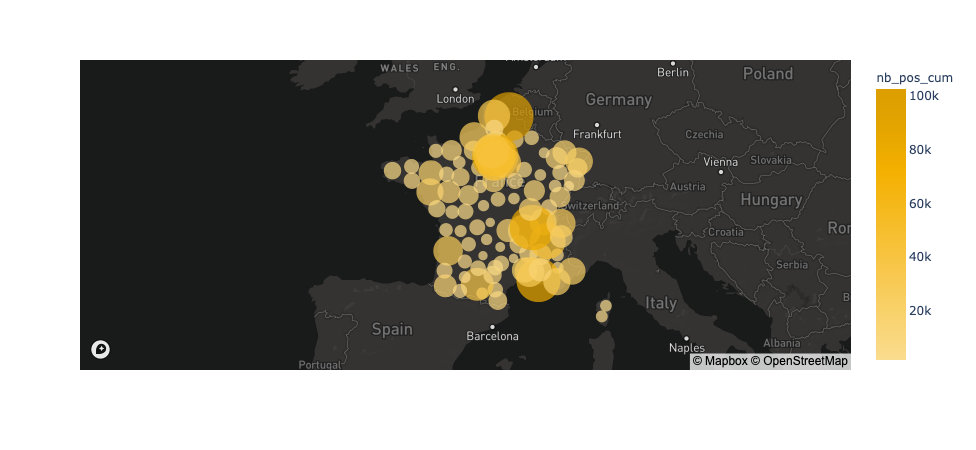

In [1427]:
plot_map()

### **Graph**

In [1428]:
last_days=30
select_df="departments"
dep_number = "75"

In [1429]:
all_df={"departments":df_dep[df_dep["dep"]==dep_number],"country":df_france}

In [1430]:
df_france.head()

,jour,hosp,rea,rad,dc,nb_test,nb_pos,nb_test_cum,nb_pos_cum,lat,long,zoom,scaled,death_rate,new_death_rate,new_dc
0,2020-03-18,2972,771,816,218,1571,394,1571,394,46.4,0.5,3.5,203.616730,55.33,55.33,218.0
1,2020-03-19,4073,1002,1180,327,2098,528,3669,922,46.4,0.5,3.5,417.529025,35.47,-19.86,109.0
2,2020-03-20,5226,1297,1587,450,2454,705,6123,1627,46.4,0.5,3.5,659.401414,27.66,-7.81,123.0
3,2020-03-21,5900,1453,1811,525,783,264,6906,1891,46.4,0.5,3.5,738.186095,27.76,0.10,75.0
4,2020-03-22,6954,1674,2117,632,555,250,7461,2141,46.4,0.5,3.5,802.354504,29.52,1.76,107.0


1. **Confirmed Cases**

In [1431]:
#z=df_dep[df_dep["dep"]==dep_number]
#z.tail()

In [1432]:
def confirmed_cases(selected_df,last_days_nb):    
    fig_confirmed = go.Figure()
    fig_confirmed.add_trace(
        go.Scatter(
            x=selected_df['jour'].tail(last_days_nb),
            y=selected_df['nb_pos_cum'].tail(last_days_nb),
            mode="lines",
            line={"color":"#f9d67a"},
            showlegend=False,
            #name="Total Confirmed Cases"
        )
    )
    fig_confirmed.add_trace(
        go.Bar(
            x=selected_df['jour'].tail(last_days),
            y=selected_df['nb_pos'].tail(last_days),
            marker={"color":"#f9d67a"},
            showlegend=False,
            #name="New Confirmed Cases",

        )
    )


    # LINE CHART ANNOTATION
    fig_confirmed.add_annotation(
         x=selected_df['jour'].tail(1).tolist()[0],
         y=selected_df['nb_pos_cum'].tail(1).tolist()[0],
         text="Total Confirmed Cases",
         font={"size": 14,"color":"#ffffff"},
         xshift=-220,  # Annotation x displacement!
         showarrow=False,
    )

    # BAR CHART ANNOTATION
    fig_confirmed.add_annotation(
        x=selected_df['jour'].tail(1).tolist()[0],
        y=selected_df['nb_pos'].tail(1).max(),
        text="New Confirmed Cases",
        font={"size": 14, "color":"#ffffff"},
        xshift=-60,  # Annotation x displacement!
        yshift=20,  # Annotation y displacement!
        showarrow=False,
        )
    fig_confirmed.update_layout(
        template="plotly_dark",
        xaxis={"title":"Dates"},
        yaxis={"title":"Number of cases"},
        autosize=True,
    )
    fig_confirmed.show()

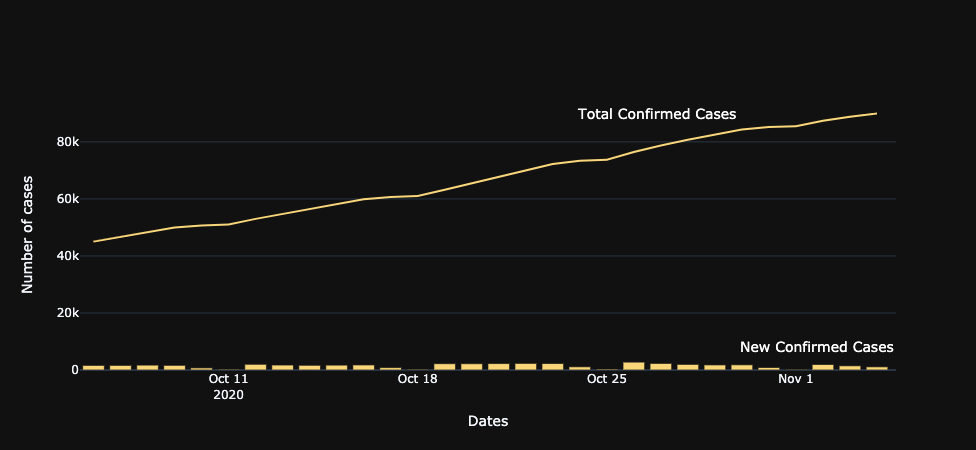

In [1433]:
confirmed_cases(all_df[select_df],last_days)

2. **Covid19 Deaths**

In [1434]:
def covid_deaths(selected_df,last_days_nb):    
    fig_confirmed = go.Figure()
    fig_confirmed.add_trace(
        go.Scatter(
            x=selected_df['jour'].tail(last_days_nb),
            y=selected_df['dc'].tail(last_days_nb),
            mode="lines",
            line={"color":"#C616C4"},
            showlegend=False,
            #name="Total Confirmed Cases"
        )
    )
    fig_confirmed.add_trace(
        go.Bar(
            x=selected_df['jour'].tail(last_days_nb),
            y=selected_df['new_dc'].tail(last_days_nb),
            marker={"color":"#C616C4"},
            showlegend=False,
            #name="New Confirmed Cases",

        )
    )


    # LINE CHART ANNOTATION
    fig_confirmed.add_annotation(
         x=selected_df['jour'].tail(1).tolist()[0],
         y=selected_df['dc'].tail(1).tolist()[0],
         text="Total Deaths",
         font={"size": 14,"color":"#ffffff"},
         xshift=-220,  # Annotation x displacement!
         showarrow=False,
    )

    # BAR CHART ANNOTATION
    fig_confirmed.add_annotation(
        x=selected_df['jour'].tail(1).tolist()[0],
        y=selected_df['new_dc'].tail(1).max(),
        text="New Deaths",
        font={"size": 14, "color":"#ffffff"},
        xshift=-60,  # Annotation x displacement!
        yshift=20,  # Annotation y displacement!
        showarrow=False,
        )
    fig_confirmed.update_layout(
        template="plotly_dark",
        xaxis={"title":"Dates"},
        yaxis={"title":"Number of deaths"},
        autosize=True,
    )
    fig_confirmed.show()

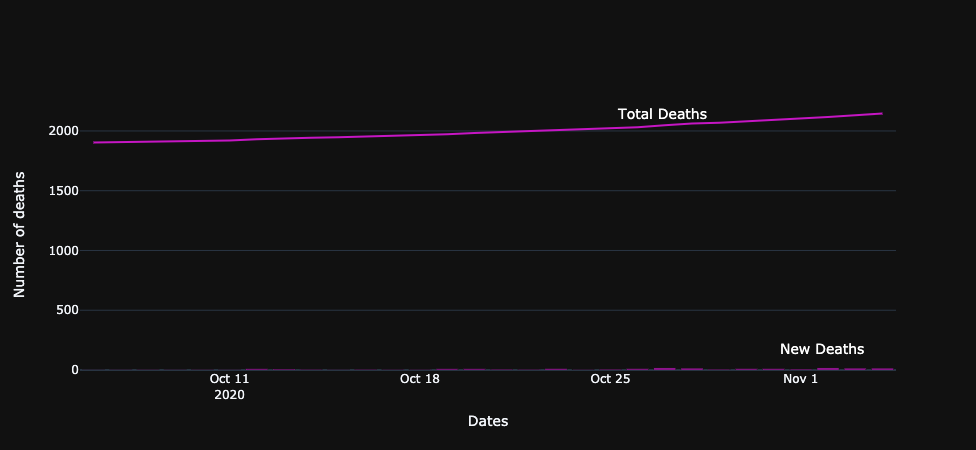

In [1435]:
covid_deaths(all_df[select_df],last_days)

In [1436]:
df = pd.read_csv('datasets/covid_19_data.csv')

In [1437]:
#df.head()

In [1438]:
#df['Country/Region'].unique()

In [1439]:
df = df.drop(df[(df["Country/Region"]=="('St. Martin',)")].index)

In [1440]:
countries = df['Country/Region'].unique()
countries.sort()

In [1441]:
df_country=df.groupby(['Country/Region','ObservationDate'])[["Confirmed","Deaths","Recovered"]].sum().reset_index()
df_country.head()

,Country/Region,ObservationDate,Confirmed,Deaths,Recovered
0,Azerbaijan,02/28/2020,1.0,0.0,0.0
1,Afghanistan,02/24/2020,1.0,0.0,0.0
2,Afghanistan,02/25/2020,1.0,0.0,0.0
3,Afghanistan,02/26/2020,1.0,0.0,0.0
4,Afghanistan,02/27/2020,1.0,0.0,0.0


In [1442]:
df_france=df_country[(df_country["Country/Region"]=="France")]
df_france.head()

,Country/Region,ObservationDate,Confirmed,Deaths,Recovered
12088,France,01/24/2020,2.0,0.0,0.0
12089,France,01/25/2020,3.0,0.0,0.0
12090,France,01/26/2020,3.0,0.0,0.0
12091,France,01/27/2020,3.0,0.0,0.0
12092,France,01/28/2020,4.0,0.0,0.0


In [1443]:
df_france.iloc[-1][:]

Country/Region         France
ObservationDate    09/23/2020
Confirmed              508456
Deaths                  31447
Recovered               96498
Name: 12331, dtype: object

In [1444]:
y_data = np.array([
    df_france['Confirmed_acc'],
    df_france['Deaths_acc'],
    df_france['Recovered']
])
labels = ['Confirmed', 'Deaths', 'Recovered']
colors = ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)']
line_size = [2, 4, 2]

KeyError: 'Confirmed_acc'

In [ ]:
fig = go.Figure()

for i in range(0, 3):
    fig.add_trace(go.Scatter(x=df_france['ObservationDate'], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

fig.show()